# Detector de Texto para OCR
Este modelo pretende detectar la resencia de texto en una imagen y en lo posible retornar las lineas de texto y cajas de los carcteres que las componen.

Modelo basado en yolo 8

## Importación de Librerias

In [40]:
#!pip install -q ultralytics
from ultralytics import YOLO

In [1]:
#Importo librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import cv2
import random
from PIL import Image, ImageFilter, ImageDraw, ImageFont
from IPython.display import Image as ImageDisplay
from IPython.core.display import HTML
from io import BytesIO
import base64
from sklearn.model_selection import train_test_split

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Generacion del dataset

In [ ]:
#Descomprimo las fuentes

#!unzip /content/drive/MyDrive/tp_integrador/fuentes.zip -d /content/

Archive:  /content/drive/MyDrive/tp_integrador/fuentes.zip
  inflating: /content/ocr_fonts_latin/Noto_Sans_Nag_Mundari/Noto_Sans_Nag_Mundari-700.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_Mayan_Numerals/Noto_Sans_Mayan_Numerals-regular.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_Oriya/Noto_Sans_Oriya-600.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_NKo_Unjoined/Noto_Sans_NKo_Unjoined-regular.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_Meetei_Mayek/Noto_Sans_Meetei_Mayek-800.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_Meetei_Mayek/Noto_Sans_Meetei_Mayek-700.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_Meetei_Mayek/Noto_Sans_Meetei_Mayek-500.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_NKo_Unjoined/Noto_Sans_NKo_Unjoined-700.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_Nag_Mundari/Noto_Sans_Nag_Mundari-regular.ttf  
  inflating: /content/ocr_fonts_latin/Noto_Sans_Nag_Mundari/Noto_Sans_Nag_Mundari-500.ttf  
  inf

In [2]:
#Creo un dataset con las fuentes
def create_font_dataset(base_folder):
    """
    Crea un DataFrame de Pandas con información sobre las fuentes TTF encontradas.

    Args:
        base_folder (str): Ruta a la carpeta principal que contiene las subcarpetas de tipos de letra.

    Returns:
        pd.DataFrame: DataFrame con columnas 'font_name' y 'font_path'.
    """
    font_data = []
    print(f"Buscando archivos .ttf en: {base_folder}")
    for font_type_folder in os.listdir(base_folder):
        font_type_path = os.path.join(base_folder, font_type_folder)
        if not os.path.isdir(font_type_path):
            continue

        ttf_files = [f for f in os.listdir(font_type_path) if f.lower().endswith('.ttf')]

        if not ttf_files:
            print(f"Advertencia: No se encontraron archivos .ttf en '{font_type_path}'. Saltando.")
            continue

        # Asumimos un único archivo .ttf por carpeta de tipo de letra o elegimos el primero
        font_file_name = ttf_files[0]
        full_font_path = os.path.join(font_type_path, font_file_name)

        font_data.append({
            'font_name': font_type_folder, # Usamos el nombre de la carpeta como nombre de la fuente
            'font_path': full_font_path
        })

    return pd.DataFrame(font_data)

In [173]:
def generate_palabras(char_list_original, min_len=2, max_len=4):

    # 1. Convertir la cadena original a una lista y desordenarla una única vez
    shuffled_char_pool = list(char_list_original)
    random.shuffle(shuffled_char_pool)

    generated_combinations = []

    pool_index = 0
    total_pool_len = len(shuffled_char_pool)

    while pool_index < total_pool_len:
        # Calcular cuántos caracteres quedan en el pool
        remaining_chars = total_pool_len - pool_index

        # Determinar la longitud de la combinación actual
        # Si quedan 7 o menos caracteres (o menos de max_len) y al menos min_len, usa todos los restantes.
        # De lo contrario, elige una longitud aleatoria entre min_len y max_len.
        if remaining_chars <= max_len:
            current_len = remaining_chars
        else:
            current_len = random.randint(min_len, max_len)
            # Asegurarse de que la longitud elegida no exceda los caracteres restantes
            current_len = min(current_len, remaining_chars)

        # Extraer la combinación del pool
        combination_chars = shuffled_char_pool[pool_index : pool_index + current_len]
        combination = "".join(combination_chars)

        generated_combinations.append(combination)
        pool_index += current_len # Mover el índice al siguiente punto en el pool

    print(f"Número de palabras generadas: {len(generated_combinations)}")
    return generated_combinations

In [158]:
# prompt: quiero una funcion que reciba una imagen de cv en escala de grises y le aplique blur gausieano y la devuelva en el mismo formato

def apply_gaussian_blur(image_gray, ksize=(3, 3), sigmaX=0):
    """
    Aplica un filtro de desenfoque Gaussiano a una imagen en escala de grises.

    Args:
        image_gray (np.ndarray): Imagen de entrada en escala de grises (array NumPy).
        ksize (tuple): Tamaño del kernel Gaussiano. Debe ser una tupla de números
                       enteros impares positivos (ancho, alto).
        sigmaX (float): Desviación estándar del kernel en la dirección X. Si es 0,
                        se calcula automáticamente en función del tamaño del kernel.

    Returns:
        np.ndarray: La imagen desenfocada como un array NumPy en escala de grises.
    """
    if len(image_gray.shape) != 2:
        print("Advertencia: La imagen de entrada no está en escala de grises. Intentando convertir.")
        image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)

    blurred_image = cv2.GaussianBlur(image_gray, ksize, sigmaX)
    return blurred_image


In [159]:
def obtener_dimensiones_contorno_caracter(caracter:str, ruta_fuente:str, tamano_fuente:int):

    # Dimensiones de la imagen base (suficientemente grande para cualquier caracter)
    img_width, img_height = tamano_fuente * 2, tamano_fuente * 2

    # Crear una imagen en blanco con fondo negro
    img = Image.new('L', (img_width, img_height), color=0) # 'L' para escala de grises
    d = ImageDraw.Draw(img)

    font = ImageFont.truetype(ruta_fuente, tamano_fuente)

    # Calcular el tamaño del texto para centrarlo
    bbox = d.textbbox((0,0), caracter, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Calcular la posición para centrar el texto
    x = (img_width - text_width) // 2
    y = (img_height - text_height) // 2

    # Dibujar el caracter en blanco sobre fondo negro
    d.text((x, y), caracter, font=font, fill=255)

    # Convertir la imagen de Pillow a un array de NumPy para OpenCV
    img_np = np.array(img)

    # Encontrar contornos
    contours, _ = cv2.findContours(img_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0, 0  # No se encontraron contornos

    all_points = np.vstack(contours)
    # Encontrar el rectángulo delimitador para el contorno combinado
    x, y, w, h = cv2.boundingRect(all_points)
    return x, y, w, h


In [175]:
characters_to_generate = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
font_df = create_font_dataset('c:/tmp/content/ocr_fonts_latin')
palabras_a_generar = []
repeticiones = 8

if not font_df.empty:
    for index, font_row in font_df.iterrows():
        font_name = font_row['font_name']
        font_path = font_row['font_path']
        print(f"Generando caracteres para la fuente: {font_name} ({font_path})")
        for i in range(repeticiones):
            lista_actual = generate_palabras(characters_to_generate)
            for palabra in lista_actual:
                palabras_a_generar.append({'palabra':palabra,'font_name':font_name,'font_path':font_path})

random.shuffle(palabras_a_generar)
print(f"Total de palabras a generar: {len(palabras_a_generar)}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Número de palabras generadas: 21
Número de palabras generadas: 21
Número de palabras generadas: 23
Número de palabras generadas: 21
Generando caracteres para la fuente: Enriqueta (c:/tmp/content/ocr_fonts_latin\Enriqueta\Enriqueta-500.ttf)
Número de palabras generadas: 22
Número de palabras generadas: 21
Número de palabras generadas: 20
Número de palabras generadas: 20
Número de palabras generadas: 21
Número de palabras generadas: 21
Número de palabras generadas: 20
Número de palabras generadas: 20
Generando caracteres para la fuente: Ephesis (c:/tmp/content/ocr_fonts_latin\Ephesis\Ephesis-regular.ttf)
Número de palabras generadas: 21
Número de palabras generadas: 21
Número de palabras generadas: 21
Número de palabras generadas: 20
Número de palabras generadas: 23
Número de palabras generadas: 20
Número de palabras generadas: 20
Número de palabras generadas: 22
Generando caracteres para la fuente: Epilogue (c:/tmp/conte

In [184]:
import math
def generar_imagen_multifuente(palabras_fuentes, output_path=None):

    # Configuración base
    img_size = 256
    margen = 10

    # Seleccionar parámetros comunes para toda la imagen
    tamano_fuente = random.randint(32, 48)
    separacion_lineas = random.choice([10, 15, 20, 25])
    espaciado_caracteres = random.choice([ 2, 3, 4, 5, 6, 7, 8])

    # Crear imagen PIL (fondo negro)
    img_pil = Image.new('L', (img_size, img_size), color=0)
    draw = ImageDraw.Draw(img_pil)

    # Listas para resultados
    bboxes = []
    caracteres = []

    # Pre-calcular altura total
    alto_total = len(palabras_fuentes) * tamano_fuente + (len(palabras_fuentes) - 1) * separacion_lineas
    y_actual = (img_size - alto_total) // 2

    funtes_anchas = ['Asset','Ballet','BioRhyme_Expanded','BIZ_UDPGothic','Bowlby_One_SC','Bungee_Shade',
                     'Castoro','Cinzel_Decorative','Climate_Crisis','Corben','Diplomata','Diplomata_SC',
                     'Edu_AU_VIC_WA_NT_Guides','Fredericka_the_Great','Grechen_Fuemen','Holtwood_One_SC',
                     'Julius_Sans_One','Krona_One','Faster_One','Lexend_Peta','Lugrasimo','Lumanosimo','Mea_Culpa','Meddon',
                     'Meie_Script','Michroma','Miss_Fajardose','Monsieur_La_Doulaise','Lavishly_Yours','My_Soul','Norican',
                     'Nosifer','Sixtyfour','Sixtyfour_Convergence']

    # Procesar cada palabra con su fuente
    for idx, row in enumerate(palabras_fuentes):
        palabra = row['palabra']
        fuente = row['font_name']
        ruta_fuente = row['font_path']
        try:
            font = ImageFont.truetype(ruta_fuente, tamano_fuente)
        except Exception as e:
            raise ValueError(f"Error cargando fuente {ruta_fuente}: {str(e)}")

        # Calcular ancho de la palabra con espaciado
        try:
            ancho_palabra = sum(draw.textlength(c, font=font) + espaciado_caracteres for c in palabra) - espaciado_caracteres
        except:
            print(f"error calculando el ancho para la fuente {fuente}")
            continue
        if ancho_palabra <= 180:
            tamano_fuente = 32
            espaciado_caracteres = 3
        elif fuente in funtes_anchas and len(palabra) > 3:
            tamano_fuente = 30
            espaciado_caracteres = 2

        font = ImageFont.truetype(ruta_fuente, tamano_fuente)
        ancho_palabra = sum(draw.textlength(c, font=font) + espaciado_caracteres for c in palabra) - espaciado_caracteres

        # Posición horizontal (centrado)
        x_actual = (img_size - ancho_palabra) // 2

        # Procesar cada caracter
        for caracter in palabra:
            try:
                # Calcular bbox
                left, top, right, bottom = font.getbbox(caracter)
                ancho_car = draw.textlength(caracter, font=font)
                ancho_car = int(math.ceil(ancho_car))
                _, _, ancho_real, _ = obtener_dimensiones_contorno_caracter(caracter, ruta_fuente, tamano_fuente)
                x_caja = x_actual - abs(max(ancho_real,right,ancho_car) - min(ancho_real,right,ancho_car))
                bbox = [
                    int(max(x_caja,1)),
                    int(y_actual + top),
                    int(x_actual + max(ancho_real, ancho_car, right)),
                    int(y_actual + bottom)
                ]
                if x_caja <= 0 or x_actual + max(ancho_real, ancho_car, right) >= (img_size - 20):
                    print(f"fuente ancha: {fuente}")
                bboxes.append(bbox)
                caracteres.append(caracter)

                # Dibujar caracter
                draw.text(
                    (x_actual, y_actual),
                    caracter,
                    font=font,
                    fill=255
                )

                # Mover posición horizontal
                x_actual += max(ancho_real, ancho_car, right) + espaciado_caracteres
            except:
                print(f"no se pudo procesar el cacarcter '{caracter}' para la fuente {fuente}")

        # Mover posición vertical
        y_actual += tamano_fuente + separacion_lineas

    # Convertir a OpenCV
    img_cv2 = np.array(img_pil)

    #aplico blue al 20%
    if random.random() < 0.2:
        img_cv2 = apply_gaussian_blur(img_cv2)

    if output_path:
        cv2.imwrite(output_path, img_cv2)

    return img_cv2, bboxes, caracteres

In [153]:
for idx, row in enumerate(palabras_a_generar):
    # Verificamos si la clave 'palabra' existe en el diccionario
    if 'palabra' in row:
        # Accedemos al valor de la clave 'palabra' y verificamos si contiene los caracteres
        if 'VMW3' in row['palabra'].upper():
            print(format(row))

{'palabra': '6VMW3O0', 'font_name': 'Lavishly_Yours', 'font_path': 'c:/tmp/content/ocr_fonts_latin\\Lavishly_Yours\\Lavishly_Yours-regular.ttf'}


In [189]:
max_palabras_imagen=3
info_imagenes = []
data_imagenes = []
index_imagen = 0
palabras_generadas = 0
index_actual = 0

print(f"Total de palabras a generar: {len(palabras_a_generar)}")

if len(palabras_a_generar) > 0:
    while index_actual < len(palabras_a_generar):
        if index_actual % 500 == 0:
            print(f"{index_actual * 100 // len(palabras_a_generar)}% completado.")
        cantidad_actual = random.randint(1, max_palabras_imagen)
        cantidad_actual = min(cantidad_actual, len(palabras_a_generar) - index_actual)
        palabras_actuales = palabras_a_generar[index_actual : index_actual + cantidad_actual]
        img_cv2, bboxes, caracteres = generar_imagen_multifuente(palabras_actuales)
        info_imagenes.append({'labels':caracteres,'fuente':font_name,'index':index_imagen})
        data_imagenes.append({'imagen':img_cv2,'bboxes':bboxes,'index':index_imagen})
        index_actual += cantidad_actual
        index_imagen += 1
    print(f"total: {index_imagen} imagenes generadas")

Total de palabras a generar: 149791
0% completado.
error calculando el ancho para la fuente Kumar_One_Outline
error calculando el ancho para la fuente Kumar_One
error calculando el ancho para la fuente Kumar_One_Outline
0% completado.
no se pudo procesar el cacarcter 'm' para la fuente Noto_Nastaliq_Urdu
fuente ancha: Miss_Fajardose
1% completado.
no se pudo procesar el cacarcter 'v' para la fuente Noto_Nastaliq_Urdu
error calculando el ancho para la fuente Kumar_One_Outline
error calculando el ancho para la fuente Kumar_One_Outline
error calculando el ancho para la fuente Kumar_One_Outline
1% completado.
error calculando el ancho para la fuente Kumar_One_Outline
error calculando el ancho para la fuente Kumar_One
error calculando el ancho para la fuente Kumar_One
error calculando el ancho para la fuente Kumar_One_Outline
2% completado.
error calculando el ancho para la fuente Kumar_One_Outline
error calculando el ancho para la fuente Kumar_One
error calculando el ancho para la fuente K

Index: 25093, Letras: ['L', 'k'], Fuente: Xanh_Mono


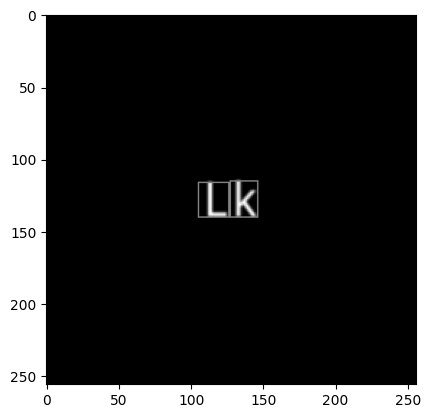



Index: 12732, Letras: ['3', 'l', '6', 'O', '6', 'p', 'O', '7'], Fuente: Xanh_Mono


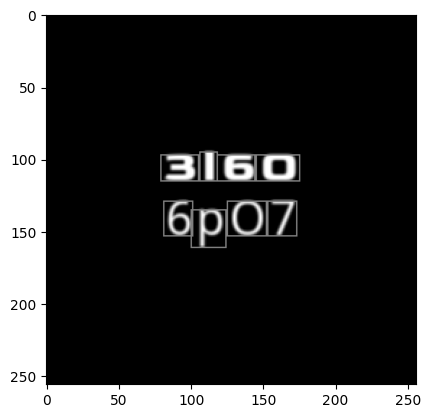



Index: 40968, Letras: ['i', 'f', 'A', 't'], Fuente: Xanh_Mono


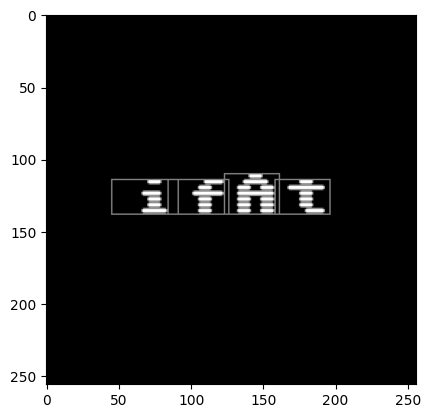



Index: 10704, Letras: ['n', 'Q', 'k', 'H', 'u'], Fuente: Xanh_Mono


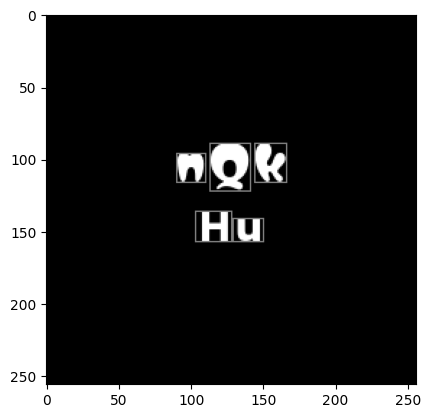



Index: 66619, Letras: ['f', '8'], Fuente: Xanh_Mono


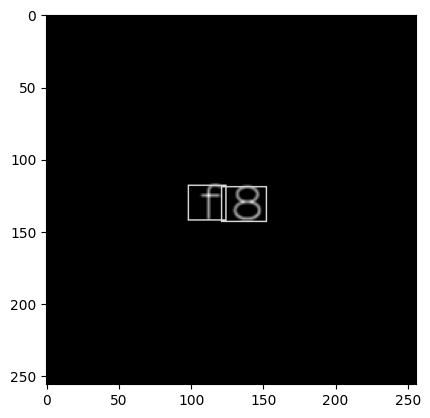



Index: 4591, Letras: ['G', 'X', '9', 'Z', 'r', 'c', 'W'], Fuente: Xanh_Mono


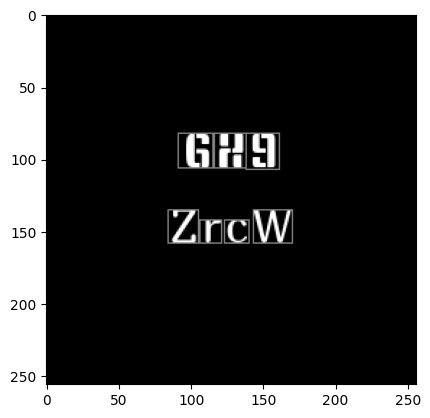



Index: 53706, Letras: ['d', 'R', 'C', 'I', 'o', 'P', '9', 'q', 'v', 'U'], Fuente: Xanh_Mono


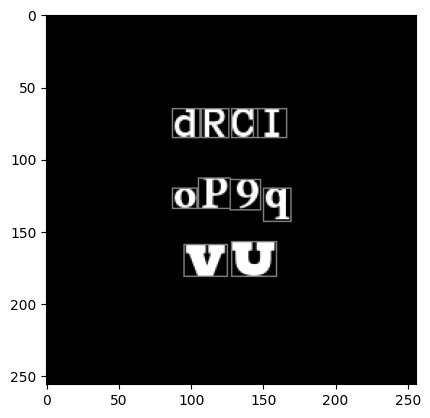



Index: 28792, Letras: ['W', 'L', 'S', 'n', 'L'], Fuente: Xanh_Mono


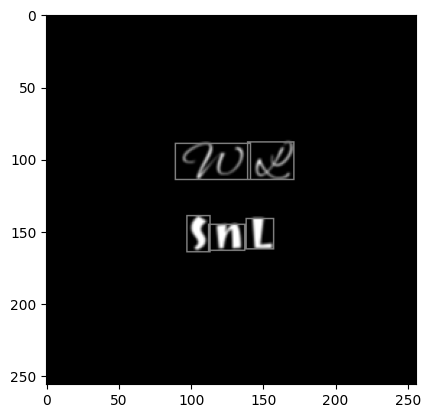



Index: 10754, Letras: ['m', 'A', 'f', 'R'], Fuente: Xanh_Mono


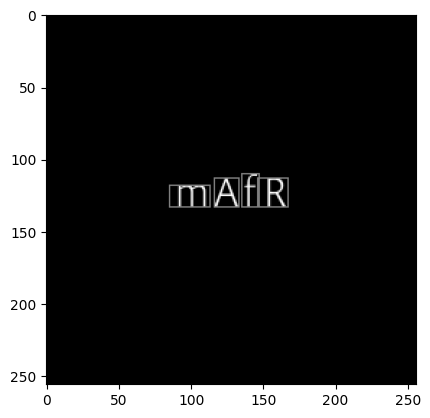



Index: 19589, Letras: ['v', 'i', 's', 'M', 'X', 'h'], Fuente: Xanh_Mono


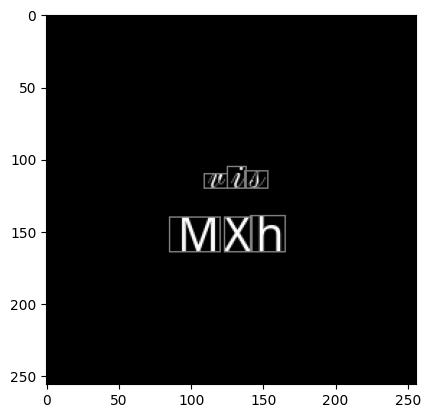



Index: 74758, Letras: ['E', '6', 'c', '0', 'X', 'P'], Fuente: Xanh_Mono


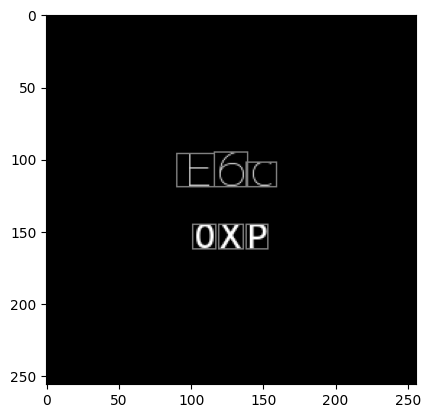



Index: 28880, Letras: ['6', 'f'], Fuente: Xanh_Mono


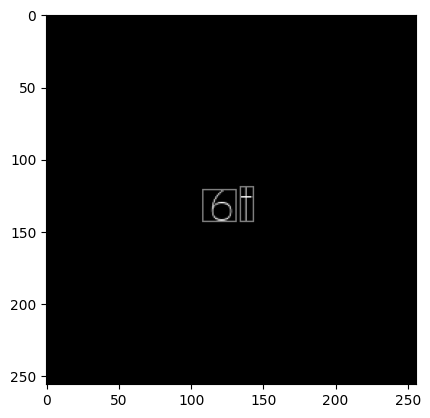



Index: 69178, Letras: ['I', 'M', 'C', 'I', 'D', 'M'], Fuente: Xanh_Mono


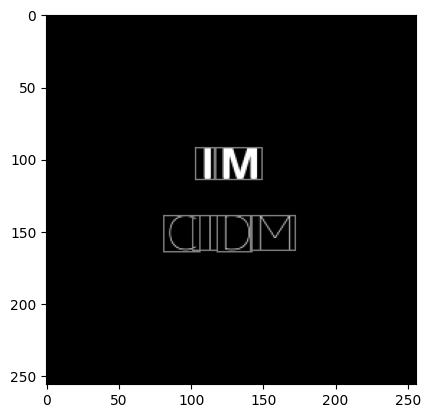



Index: 407, Letras: ['v', 'W', '8', 'R', '1', 'R', '0', 'M', 'X'], Fuente: Xanh_Mono


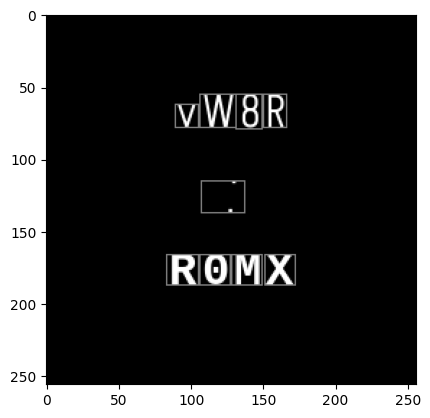



Index: 26381, Letras: ['U', 'c', 'e', 'F', 'y', 'G', 'B', '5', '2'], Fuente: Xanh_Mono


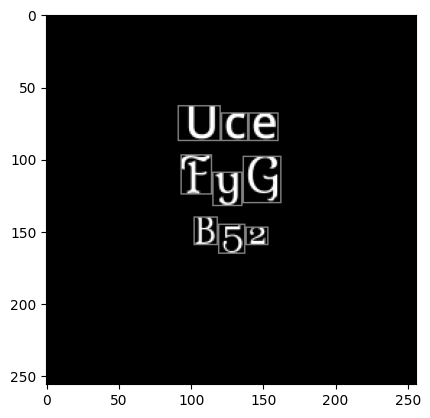



Index: 54726, Letras: ['g', 'A', 'K', 'D', '4', 'e', 'Q', 'P'], Fuente: Xanh_Mono


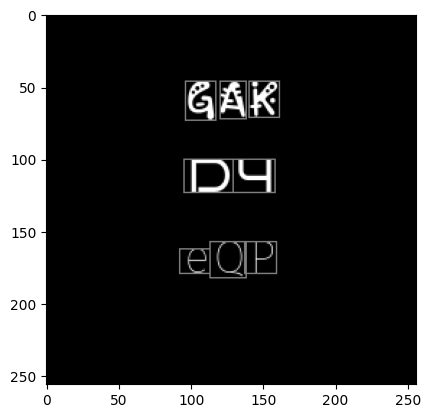



Index: 38821, Letras: ['c', 'd', 'j', 's', 'i', 'W', 'x'], Fuente: Xanh_Mono


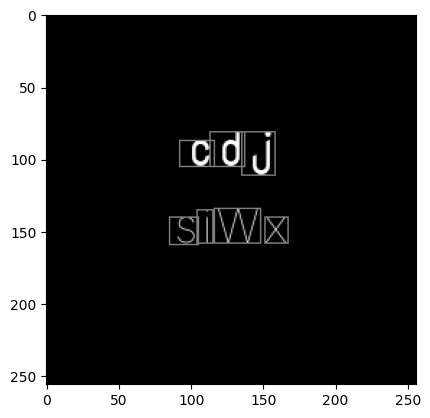



Index: 19955, Letras: ['Z', '0', '1', 'p'], Fuente: Xanh_Mono


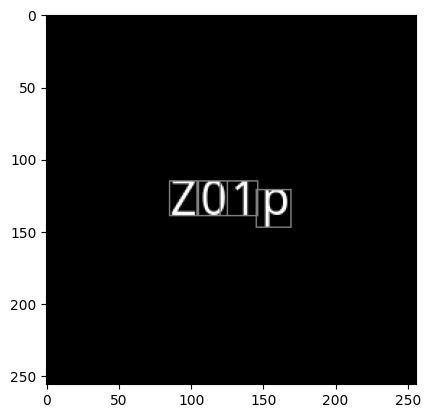



Index: 22738, Letras: ['C', '1', 'Q', 'S', '9', 'M', '5', 'R'], Fuente: Xanh_Mono


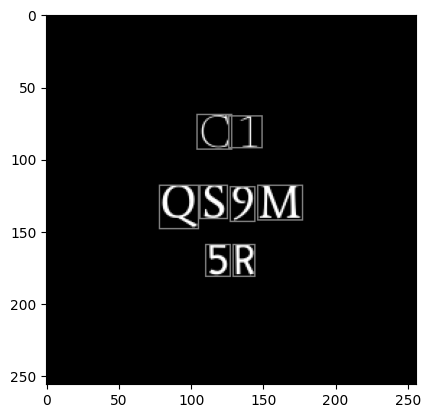



Index: 68462, Letras: ['k', 'O', 'S', 'r'], Fuente: Xanh_Mono


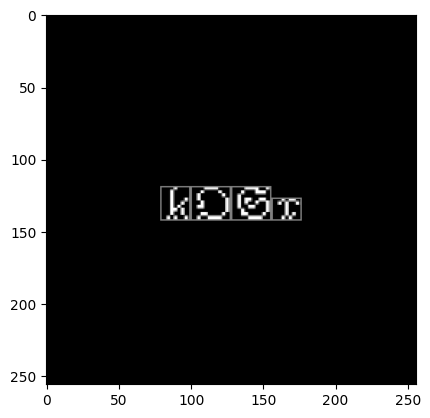

In [190]:
pandas_dataset = pd.DataFrame(info_imagenes)
numpy_dataset = np.array(data_imagenes)
muestra = pandas_dataset.sample(20)
for index, row in muestra.iterrows():
    print(f"Index: {row['index']}, Letras: {row['labels']}, Fuente: {row['fuente']}")
    img_muestra = numpy_dataset[row['index']]['imagen']
    bboxes= numpy_dataset[row['index']]['bboxes']
    for bbox in bboxes:
        cv2.rectangle(img_muestra, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (128, 128, 128), 1)
    plt.imshow(img_muestra, cmap='gray')
    plt.show()
    print("\n")

## Dataset de entrenamiento
Este dataset contendra imagenes de carcateres y las coordenadas de la caja que los contiene

## Generacion de archivos de entrenamiento

In [179]:
# Configuración del archivo data.yaml para YOLOv8
characters_to_generate = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
class_id_to_char = {i: char for i, char in enumerate(characters_to_generate)}
names_string = "["
for char in characters_to_generate:
    if char == characters_to_generate[-1]:
        names_string += f"'{char}'"
    else:
        names_string += f"'{char}', "
names_string += "]"

config = f"""
# YOLOv8 Character Detection Configuration
path: c:/tmp/content/training
train: images/train
val: images/val

# Class settings
nc: {len(characters_to_generate)}
names: {names_string}

depth_multiple: 0.67  # Más capacidad para detalles finos
width_multiple: 0.75  # Más ancho de canales

# Detection parameters
anchors:
  - [3,5, 5,8, 8,12]       # Pequeños (i, l, 1)
  - [12,16, 16,24, 24,32]  # Medianos (a, e, 0)
  - [32,48, 48,64, 64,96]  # Grandes (W, M)

# Augmentation (recommended for text)
augment:
  rotation: [-15, 15]     # Random rotation
  shear: [-5, 5]          # Shear transformation
  scale: [0.9, 1.1]       # Scale variation
  translate: [0.1, 0.1]   # Random translation

# Training params (optional)
train_params:
  lr0: 0.01               # Initial learning rate
  lrf: 0.1                # Final learning rate
  momentum: 0.937         # SGD momentum
  weight_decay: 0.0005    # Optimizer weight decay
  warmup_epochs: 3        # Warmup epochs

# Model hyperparameters
backbone:
  - [-1, 1, Conv, [64, 3, 2]]  # 0-P1/2
  - [-1, 1, Conv, [128, 3, 2]] # 1-P2/4
  - [-1, 3, C2f, [128, True]]
  - [-1, 1, Conv, [256, 3, 2]] # 3-P3/8
  - [-1, 6, C2f, [256, True]]
  - [-1, 1, Conv, [512, 3, 2]] # 5-P4/16
  - [-1, 6, C2f, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]] # 7-P5/32
  - [-1, 3, C2f, [1024, True]]
  - [-1, 1, SPPF, [1024, 5]] # 9

# Head
head:
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]  # cat backbone P4
  - [-1, 3, C2f, [512]]  # 12

  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 4], 1, Concat, [1]]  # cat backbone P3
  - [-1, 3, C2f, [256]]  # 15 (P3/8-small)

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 12], 1, Concat, [1]]  # cat head P4
  - [-1, 3, C2f, [512]]  # 18 (P4/16-medium)

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]  # cat head P5
  - [-1, 3, C2f, [1024]]  # 21 (P5/32-large)

  - [[15, 18, 21], 1, Detect, [nc]]  # Detect(P3, P4, P5)
"""

with open("data.yaml", 'w', encoding='utf-8') as f:
    f.write(config.strip())
    print(f"Archivo de configuración generado en data.yaml")

# Generar el diccionario propio con ID y letra
class_id_to_char = {i: char for i, char in enumerate(characters_to_generate)}


def get_id_by_char(char):
    """
    Busca el ID de clase dado un carácter, iterando directamente sobre el diccionario.
    Devuelve el ID si se encuentra, None si el carácter no está en las clases.
    """
    for class_id, stored_char in class_id_to_char.items():
        if stored_char == char:
            return class_id
    return None # Si el carácter no se encontró después de buscar en todo el diccionario

def get_char_by_id(class_id):
    return class_id_to_char.get(class_id)

Archivo de configuración generado en data.yaml


In [192]:
os.makedirs('c:/tmp/content/training/images/train', exist_ok=True)
os.makedirs('c:/tmp/content/training/images/val', exist_ok=True)
os.makedirs('c:/tmp/content/training/labels/train', exist_ok=True)
os.makedirs('c:/tmp/content/training/labels/val', exist_ok=True)

# Obtener el número total de muestras
num_samples = numpy_dataset.size
indices = list(range(num_samples)) # Generar índices de 0 a num_samples-1
train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=42)

def save_image_and_label(idx, image, labels_list, bboxes_list, split):
    """
    Guarda una imagen y su archivo de etiquetas en formato YOLO.

    Args:
        idx (int): Índice de la imagen (usado para el nombre del archivo).
        image (np.array): Datos de la imagen (en escala de grises, asumido 0-1 o 0-255).
        bboxes_list (list): Lista de bounding boxes para la imagen.
                            Cada bbox es una lista/tupla [x_min, y_min, x_max, y_max].
                            Puede estar vacía si no hay caracteres.
        split (str): 'train' o 'val', para determinar el directorio de destino.
    """
    img_path = f'c:/tmp/content/training/images/{split}/{idx}.png'
    label_path = f'c:/tmp/content/training/labels/{split}/{idx}.txt'


    # Obtener las dimensiones de la imagen guardada para la normalización
    h, w = image.shape # Asume que la imagen es 2D (escala de grises)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    img_to_save = Image.fromarray(image)
    img_to_save.save(img_path, format='PNG', optimize=True)

    # Abre el archivo de etiquetas para escribir las coordenadas de todos los bboxes
    with open(label_path, 'w') as f:
        for label, bbox in zip(labels_list, bboxes_list):
            x_min, y_min, x_max, y_max = bbox

            # Formato YOLO: class x_center y_center width height (normalizado)
            xc = (x_min + x_max) / 2 / w
            yc = (y_min + y_max) / 2 / h
            bw = (x_max - x_min) / w
            bh = (y_max - y_min) / h

            label_id = get_id_by_char(label)
            if label_id is None:
                print(f"Advertencia: El carácter '{label}' no se encontró en las clases. Saltando.")
                continue

            f.write(f'{label_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n')


# Bucle principal para procesar y guardar imágenes y etiquetas
# CAMBIO PRINCIPAL: Iteración sobre los índices directamente y acceso al dataset NumPy
total = len(indices)
contador = 1
for idx in indices: # Iteramos sobre la lista de índices generada
    split = 'train' if idx in train_idx else 'val'
    if contador % 500 == 0:
        print(f"{(contador * 100) // total}% completado.")
    contador += 1

    fila_actual = numpy_dataset[idx]
    # Accedemos a la imagen y su lista de bboxes usando el índice actual
    current_image = fila_actual['imagen']
    current_bboxes = fila_actual['bboxes']
    index = fila_actual['index']
    current_data = pandas_dataset[pandas_dataset['index'] == index].iloc[0]
    if current_data.empty:
        print(f"Advertencia: No se encontraron datos para el índice {index}. Saltando.")
    current_labels = current_data['labels']

    save_image_and_label(idx, current_image, current_labels, current_bboxes, split)

0% completado.
1% completado.
2% completado.
2% completado.
3% completado.
4% completado.
4% completado.
5% completado.
6% completado.
6% completado.
7% completado.
8% completado.
8% completado.
9% completado.
10% completado.
10% completado.
11% completado.
12% completado.
12% completado.
13% completado.
14% completado.
14% completado.
15% completado.
16% completado.
16% completado.
17% completado.
18% completado.
18% completado.
19% completado.
20% completado.
20% completado.
21% completado.
22% completado.
22% completado.
23% completado.
24% completado.
24% completado.
25% completado.
26% completado.
26% completado.
27% completado.
28% completado.
28% completado.
29% completado.
30% completado.
30% completado.
31% completado.
32% completado.
32% completado.
33% completado.
34% completado.
34% completado.
35% completado.
36% completado.
36% completado.
37% completado.
38% completado.
38% completado.
39% completado.
40% completado.
40% completado.
41% completado.
42% completado.
42% co

In [194]:
import os

# Asegúrate de que 'characters_to_generate' sea exactamente la misma cadena
# que utilizaste para generar tu data.yaml
characters_to_generate = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
num_classes = len(characters_to_generate)
max_valid_id = num_classes - 1

# Asegúrate de que estas rutas son correctas y accesibles en tu sistema
label_dirs = [
    'c:/tmp/content/training/labels/train',
    'c:/tmp/content/training/labels/val'
]

print(f"Verificando etiquetas. Número de clases esperado: {num_classes} (IDs 0 a {max_valid_id})")

errors_found = False

for label_dir in label_dirs:
    print(f"\n--- Procesando directorio: {label_dir} ---")
    if not os.path.exists(label_dir):
        print(f"Advertencia: Directorio no encontrado: {label_dir}. Omite este directorio.")
        continue

    txt_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    if not txt_files:
        print(f"No se encontraron archivos .txt en {label_dir}.")
        continue

    for label_file in txt_files:
        file_path = os.path.join(label_dir, label_file)
        try:
            with open(file_path, 'r', encoding='utf-8') as f: # Añadir encoding='utf-8' por si hay caracteres especiales en las rutas o nombres
                for line_num, line in enumerate(f):
                    parts = line.strip().split()

                    # 1. Verificar si la línea está vacía
                    if not parts:
                        continue # Ignorar líneas completamente vacías

                    # 2. Verificar la cantidad correcta de valores
                    if len(parts) != 5:
                        print(f"ERROR: Cantidad incorrecta de valores en {label_file} línea {line_num+1}.")
                        print(f"  Contenido: '{line.strip()}' (Esperado: 5 valores: class_id cx cy w h)")
                        errors_found = True
                        continue # Pasa a la siguiente línea

                    try:
                        class_id = int(parts[0])

                        # 3. Verificar el rango del ID de clase
                        if not (0 <= class_id <= max_valid_id):
                            print(f"ERROR: ID de clase '{class_id}' fuera de rango en {label_file} línea {line_num+1}.")
                            print(f"  Rango válido para ID de clase: 0 a {max_valid_id}.")
                            errors_found = True

                        # 4. Verificar el rango de las coordenadas
                        # Las coordenadas son cx, cy, w, h (índices 1 a 4)
                        for i in range(1, 5):
                            val_str = parts[i]
                            val = float(val_str)
                            if not (0.0 <= val <= 1.0):
                                print(f"ERROR: Coordenada '{val_str}' fuera de rango [0.0, 1.0] en {label_file} línea {line_num+1} (posición {i}).")
                                errors_found = True
                            # Opcional: También podrías querer verificar si width o height son 0 o extremadamente pequeños
                            if i in [3, 4] and val < 0.0001: # Check for width/height being too small
                                print(f"ADVERTENCIA: Ancho/Alto muy pequeño ({val_str}) en {label_file} línea {line_num+1} (posición {i}).")

                    except ValueError:
                        print(f"ERROR: Error de tipo de dato (no numérico) en {label_file} línea {line_num+1}.")
                        print(f"  Contenido: '{line.strip()}'")
                        errors_found = True
                    except IndexError: # En caso de que split() devuelva menos elementos de lo esperado inesperadamente
                        print(f"ERROR: Error de índice al procesar línea {line_num+1} en {label_file}.")
                        print(f"  Contenido: '{line.strip()}'")
                        errors_found = True

        except FileNotFoundError:
            print(f"ERROR: Archivo no encontrado: {file_path}")
            errors_found = True
        except Exception as e:
            print(f"ERROR: Error inesperado al leer el archivo {file_path}: {e}")
            errors_found = True

print("\n--- Verificación de etiquetas completada ---")
if errors_found:
    print("¡Se encontraron errores! Por favor, revisa los mensajes de ERROR y corrige tus archivos de etiquetas.")
    print("Recuerda usar 'CUDA_LAUNCH_BLOCKING=1' para depurar el entrenamiento de YOLOv8 si el problema persiste.")
else:
    print("¡No se encontraron errores ni advertencias importantes en las etiquetas!")

Verificando etiquetas. Número de clases esperado: 62 (IDs 0 a 61)

--- Procesando directorio: c:/tmp/content/training/labels/train ---

--- Procesando directorio: c:/tmp/content/training/labels/val ---

--- Verificación de etiquetas completada ---
¡No se encontraron errores ni advertencias importantes en las etiquetas!


## Entrenamiento del Modelo YOLO 8

In [195]:
model = YOLO('yolov8n.pt')
model.train(
    data='data.yaml',
    epochs=100,
    imgsz=256,
    batch=64,
    workers=8,
    patience=10,           # Detención temprana si no mejora
    device='0',            # Usar GPU
    optimizer='AdamW',     # Mejor para texto
    lr0=0.001,            # Tasa de aprendizaje inicial
    augment=True,          # ¡CRUCIAL para caracteres!
    flipud=0.0,           # Aumentación adicional
    fliplr=0.0,
    mixup=0.1,
    copy_paste=0.1        # Útil para caracteres superpuestos
)

print("Entrenamiento del modelo YOLOv8 completado.")

New https://pypi.org/project/ultralytics/8.3.158 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.155  Python-3.9.23 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optim

train: Scanning C:\tmp\content\training\labels\train... 67416 images, 45 backgrounds, 0 corrupt: 100%|██████████| 67416


train: New cache created: C:\tmp\content\training\labels\train.cache
val: Fast image access  (ping: 0.30.1 ms, read: 4.01.6 MB/s, size: 2.3 KB)


val: Scanning C:\tmp\content\training\labels\val... 7491 images, 4 backgrounds, 0 corrupt: 100%|██████████| 7491/7491 [


val: New cache created: C:\tmp\content\training\labels\val.cache
Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs\detect\train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.76G      1.064      2.229     0.8757        197        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42


                   all       7491      44242      0.784      0.738      0.841      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.13G     0.8359     0.9341     0.8412        224        256: 100%|██████████| 1054/1054 [02:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:38


                   all       7491      44242      0.895      0.855      0.924      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.13G     0.7904     0.7937     0.8334        178        256: 100%|██████████| 1054/1054 [02:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41


                   all       7491      44242      0.918      0.878      0.943      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.13G     0.7552     0.7242     0.8285        213        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37


                   all       7491      44242      0.923      0.898      0.955      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.13G      0.727     0.6761     0.8244        331        256: 100%|██████████| 1054/1054 [02:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:44


                   all       7491      44242      0.893      0.854      0.923      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.13G     0.7084     0.6426     0.8212        227        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37


                   all       7491      44242      0.926      0.898      0.958      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.13G     0.6934     0.6195     0.8188        169        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:34


                   all       7491      44242      0.939       0.92       0.97      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.13G     0.6812     0.6036     0.8177        233        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:34


                   all       7491      44242      0.941      0.924      0.972      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.13G     0.6711     0.5888     0.8164        195        256: 100%|██████████| 1054/1054 [02:46<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:35


                   all       7491      44242      0.947      0.926      0.974      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.13G     0.6618     0.5742     0.8148        184        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:39


                   all       7491      44242      0.943      0.933      0.975      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.13G      0.651     0.5619     0.8143        217        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:39


                   all       7491      44242      0.947      0.935      0.977      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.13G     0.6449     0.5541     0.8139        241        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37


                   all       7491      44242      0.947      0.937      0.978      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.13G     0.6388     0.5477     0.8122        175        256: 100%|██████████| 1054/1054 [02:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:34


                   all       7491      44242      0.949      0.938      0.978      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.13G     0.6332     0.5429     0.8121        215        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41


                   all       7491      44242      0.948       0.94      0.979      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.13G     0.6256     0.5325     0.8113        175        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42


                   all       7491      44242      0.949       0.94      0.979      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.13G     0.6209     0.5271     0.8109        204        256: 100%|██████████| 1054/1054 [02:54<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43


                   all       7491      44242      0.952       0.94       0.98      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.13G     0.6169     0.5205     0.8097        228        256: 100%|██████████| 1054/1054 [02:55<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42


                   all       7491      44242      0.953       0.94       0.98      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.13G     0.6116     0.5157     0.8095        190        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43

                   all       7491      44242      0.954       0.94       0.98      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.13G      0.607     0.5108     0.8091        204        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42


                   all       7491      44242      0.954      0.941       0.98      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.13G      0.604     0.5069     0.8084        205        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41


                   all       7491      44242      0.955      0.941      0.981      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.13G     0.6011     0.5026     0.8087        264        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43


                   all       7491      44242      0.955      0.942      0.981       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.13G     0.5982     0.4972      0.808        194        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:38


                   all       7491      44242      0.954      0.943      0.981      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.13G     0.5955     0.4952     0.8077        223        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36


                   all       7491      44242      0.954      0.943      0.981       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.13G      0.591       0.49     0.8071        241        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37


                   all       7491      44242      0.952      0.945      0.981      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.13G     0.5911     0.4901      0.807        205        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36


                   all       7491      44242      0.953      0.946      0.982      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.13G     0.5872     0.4868     0.8068        131        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:39


                   all       7491      44242      0.952      0.947      0.982      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.13G     0.5847     0.4808     0.8064        269        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:39


                   all       7491      44242      0.952      0.947      0.982      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.13G     0.5813      0.479      0.806        264        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:40


                   all       7491      44242      0.951      0.948      0.982      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.13G     0.5809     0.4766     0.8061        213        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:40

                   all       7491      44242      0.952      0.947      0.982      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.13G     0.5779      0.475     0.8059        183        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42

                   all       7491      44242      0.953      0.947      0.982      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.13G      0.576     0.4735     0.8062        197        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:40


                   all       7491      44242      0.953      0.948      0.983      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.13G     0.5734     0.4693     0.8055        219        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43

                   all       7491      44242      0.954      0.947      0.983      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.13G     0.5716     0.4677     0.8054        213        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42


                   all       7491      44242      0.954      0.948      0.983      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.13G     0.5699     0.4629     0.8048        217        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43


                   all       7491      44242      0.955      0.948      0.983      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.13G     0.5676     0.4607     0.8047        254        256: 100%|██████████| 1054/1054 [02:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:44


                   all       7491      44242      0.955      0.948      0.983      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.13G     0.5664     0.4598     0.8043        183        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42

                   all       7491      44242      0.954       0.95      0.983      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.13G     0.5646     0.4589     0.8042        247        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36


                   all       7491      44242      0.953      0.951      0.983      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.13G     0.5618     0.4563     0.8038        278        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36

                   all       7491      44242      0.953      0.952      0.984      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.13G     0.5604      0.455     0.8041        261        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37


                   all       7491      44242      0.953      0.953      0.984      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.13G       0.56     0.4549     0.8037        199        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:38

                   all       7491      44242      0.954      0.953      0.984      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.13G     0.5576     0.4521     0.8033        234        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:38


                   all       7491      44242      0.954      0.953      0.984      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.13G     0.5577     0.4507      0.803        228        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:39


                   all       7491      44242      0.954      0.953      0.984      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.13G     0.5546     0.4487     0.8032        213        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41

                   all       7491      44242      0.953      0.954      0.984      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.13G     0.5545     0.4477     0.8028        254        256: 100%|██████████| 1054/1054 [02:54<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42


                   all       7491      44242      0.953      0.954      0.984      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.13G      0.553     0.4462     0.8032        169        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43

                   all       7491      44242      0.954      0.954      0.984      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.13G     0.5522     0.4449     0.8027        218        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42

                   all       7491      44242      0.953      0.954      0.984      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.13G       0.55     0.4441     0.8029        198        256: 100%|██████████| 1054/1054 [02:54<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42


                   all       7491      44242      0.954      0.954      0.984      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.13G      0.548     0.4423     0.8019        221        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43

                   all       7491      44242      0.955      0.954      0.984      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.13G     0.5466       0.44     0.8019        246        256: 100%|██████████| 1054/1054 [02:54<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43

                   all       7491      44242      0.955      0.954      0.984      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.13G     0.5459     0.4376     0.8024        195        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:40

                   all       7491      44242      0.954      0.955      0.985      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.13G     0.5444     0.4364     0.8023        261        256: 100%|██████████| 1054/1054 [02:54<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:38


                   all       7491      44242      0.954      0.955      0.985      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.13G     0.5439     0.4367     0.8021        236        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37

                   all       7491      44242      0.955      0.955      0.985       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.13G     0.5423     0.4341     0.8022        248        256: 100%|██████████| 1054/1054 [02:55<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36


                   all       7491      44242      0.955      0.955      0.985       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.13G     0.5407     0.4331     0.8016        238        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37

                   all       7491      44242      0.956      0.955      0.985      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.13G       0.54     0.4318     0.8014        279        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36


                   all       7491      44242      0.957      0.954      0.985      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.13G     0.5396      0.431     0.8019        245        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37


                   all       7491      44242      0.957      0.955      0.985      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.13G      0.538     0.4286     0.8009        223        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41

                   all       7491      44242      0.956      0.956      0.985      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.13G     0.5365     0.4281     0.8013        276        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:40

                   all       7491      44242      0.956      0.956      0.985      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.13G     0.5361     0.4278     0.8016        202        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41

                   all       7491      44242      0.955      0.956      0.985      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.13G     0.5351     0.4276     0.8007        262        256: 100%|██████████| 1054/1054 [02:54<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43

                   all       7491      44242      0.956      0.956      0.985      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.13G     0.5329     0.4258     0.8006        163        256: 100%|██████████| 1054/1054 [02:53<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:40

                   all       7491      44242      0.956      0.957      0.985      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.13G     0.5337     0.4247     0.8012        346        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42

                   all       7491      44242      0.955      0.958      0.985      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.13G      0.531     0.4234     0.8005        172        256: 100%|██████████| 1054/1054 [02:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:43

                   all       7491      44242      0.957      0.957      0.985      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.13G     0.5311      0.423     0.8006        303        256: 100%|██████████| 1054/1054 [02:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41


                   all       7491      44242      0.956      0.957      0.985      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.13G     0.5297     0.4204     0.8008        257        256: 100%|██████████| 1054/1054 [02:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:39

                   all       7491      44242      0.956      0.956      0.985      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.13G      0.528     0.4206     0.8002        237        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36

                   all       7491      44242      0.956      0.957      0.985      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.13G     0.5296     0.4205     0.8007        195        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36

                   all       7491      44242      0.956      0.958      0.985      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.13G      0.528     0.4187     0.8008        229        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36

                   all       7491      44242      0.956      0.957      0.986      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.13G     0.5264     0.4161     0.8003        211        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:38

                   all       7491      44242      0.956      0.958      0.986      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.13G     0.5247     0.4182     0.8001        270        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37

                   all       7491      44242      0.957      0.957      0.986      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.13G     0.5236     0.4158     0.7997        194        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36

                   all       7491      44242      0.958      0.956      0.986      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.13G     0.5236     0.4146     0.8003        232        256: 100%|██████████| 1054/1054 [02:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:42

                   all       7491      44242      0.957      0.957      0.986      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.13G     0.5227     0.4147     0.7996        222        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41

                   all       7491      44242      0.957      0.957      0.986      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.13G     0.5235     0.4145        0.8        164        256: 100%|██████████| 1054/1054 [02:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37


                   all       7491      44242      0.958      0.957      0.986      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.13G      0.521     0.4119     0.7996        264        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:38

                   all       7491      44242      0.958      0.956      0.986      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.13G     0.5212     0.4122     0.7997        222        256: 100%|██████████| 1054/1054 [02:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41

                   all       7491      44242      0.958      0.957      0.986      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.13G     0.5202     0.4124     0.7995        200        256: 100%|██████████| 1054/1054 [02:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41

                   all       7491      44242      0.958      0.957      0.986      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.13G     0.5189     0.4102     0.7991        208        256: 100%|██████████| 1054/1054 [02:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36

                   all       7491      44242      0.957      0.958      0.986      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.13G     0.5175     0.4088     0.7994        199        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:38

                   all       7491      44242      0.957      0.959      0.986      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.13G     0.5163      0.409      0.799        204        256: 100%|██████████| 1054/1054 [02:47<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36

                   all       7491      44242      0.957      0.959      0.986      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.13G     0.5171     0.4088     0.7993        262        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37

                   all       7491      44242      0.957      0.959      0.986      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.13G     0.5162     0.4098     0.7991        208        256: 100%|██████████| 1054/1054 [02:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:41

                   all       7491      44242      0.957      0.959      0.986      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.13G     0.5156     0.4092     0.7987        252        256: 100%|██████████| 1054/1054 [02:51<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37

                   all       7491      44242      0.957      0.959      0.986      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.13G     0.5153     0.4078      0.799        257        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37

                   all       7491      44242      0.956      0.959      0.986      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.13G     0.5137     0.4073     0.7988        212        256: 100%|██████████| 1054/1054 [02:50<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36


                   all       7491      44242      0.956      0.959      0.986       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.13G     0.5138     0.4058     0.7992        218        256: 100%|██████████| 1054/1054 [02:54<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37

                   all       7491      44242      0.957      0.959      0.986      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.13G     0.5127     0.4065     0.7984        210        256: 100%|██████████| 1054/1054 [02:54<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:40


                   all       7491      44242      0.957      0.959      0.986      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.13G     0.5115     0.4032     0.7985        137        256: 100%|██████████| 1054/1054 [02:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:35

                   all       7491      44242      0.957      0.959      0.986      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.13G     0.5123     0.4051     0.7986        211        256: 100%|██████████| 1054/1054 [02:48<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:37


                   all       7491      44242      0.957      0.959      0.986      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.13G     0.5097     0.4026     0.7985        227        256: 100%|██████████| 1054/1054 [02:49<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:36

                   all       7491      44242      0.957      0.959      0.986       0.86


Closing dataloader mosaic


MemoryError: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Configura la ruta de tu directorio de resultados ---
# Puedes encontrar el nombre de la carpeta de la última ejecución en la salida de tu entrenamiento.
# Por ejemplo, si tu entrenamiento más reciente guardó los resultados en 'runs/detect/train', usa eso.
# Si estás ejecutando esto inmediatamente después de entrenar, el directorio 'train' será el más reciente.
# Si hay múltiples 'trainX' carpetas, ajusta 'run_dir_name' a la correcta.
# Por ejemplo, si el último fue 'train3', sería 'train3'.
run_dir_name = 'train10' # O 'train2', 'train3', etc., según tu última ejecución.
results_path = f'C:/Users/Andres/runs/detect/{run_dir_name}/results.csv'

# Comprueba si el archivo existe antes de intentar leerlo
if not os.path.exists(results_path):
    print(f"Error: El archivo de resultados no se encontró en '{results_path}'.")
    print("Asegúrate de que la ruta sea correcta y que el entrenamiento haya finalizado.")
    print("Revisa los nombres de las carpetas en 'c:/tmp/content/runs/detect/' para encontrar la correcta.")
else:
    # Cargar los resultados en un DataFrame de pandas
    # Los resultados.csv de YOLOv8 tienen la cabecera comentada con #, así que la omitimos.
    # También hay un espacio extra antes de los nombres de columna, lo removemos.
    df_results = pd.read_csv(results_path, skipinitialspace=True)

    # Limpiar los nombres de las columnas para facilitar el acceso
    # Las columnas suelen ser como '                 metrics/precision(B)'
    df_results.columns = df_results.columns.str.strip()

    print("Métricas de entrenamiento completadas:")
    # Muestra las últimas filas del DataFrame para ver las métricas finales
    print(df_results.tail())

Métricas de entrenamiento completadas:
   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
5      6  348.149         0.62970         0.33365         0.78549   
6      7  400.771         0.60112         0.31655         0.78390   
7      8  453.348         0.57391         0.30118         0.78204   
8      9  509.248         0.55311         0.28790         0.78068   
9     10  563.207         0.53119         0.27323         0.77936   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
5               0.97232            0.84508           0.92622   
6               0.97262            0.85288           0.92461   
7               0.97651            0.86268           0.94055   
8               0.97040            0.84788           0.92935   
9               0.97457            0.85230           0.93070   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
5              0.79039       0.58643       0.33194       0.78342  0.001010   
6    

In [ ]:
   # --- Visualización de las métricas (opcional, pero muy útil) ---
if os.path.exists(results_path):
# --- Visualización de las métricas (opcional, pero muy útil) ---
    fig1 = plt.figure(figsize=(12, 6)) # Asigna la figura a una variable

    # Graficar mAP@0.50
    if 'metrics/mAP50(B)' in df_results.columns:
        plt.plot(df_results['epoch'], df_results['metrics/mAP50(B)'], label='mAP@0.50', marker='o', markersize=4)
    else:
        print("La columna 'metrics/mAP50(B)' no se encontró en los resultados.")

    # Graficar mAP@0.50-0.95
    if 'metrics/mAP50-95(B)' in df_results.columns:
        plt.plot(df_results['epoch'], df_results['metrics/mAP50-95(B)'], label='mAP@0.50-0.95', marker='x', markersize=4)
    else:
        print("La columna 'metrics/mAP50-95(B)' no se encontró en los resultados.")

    plt.title('Curva de mAP durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('mAP')
    plt.grid(True)
    plt.legend()
    plt.show() # Intenta mostrar el gráfico

    # Guarda la primera figura después de intentar mostrarla
    save_path_map = os.path.join(os.path.dirname(results_path), 'map_curve.png')
    fig1.savefig(save_path_map)
    print(f"Gráfico de mAP guardado en: {save_path_map}")
    plt.close(fig1) # Cierra la figura para liberar memoria


    fig2 = plt.figure(figsize=(12, 6)) # Asigna la segunda figura a una variable
    # Graficar la pérdida de entrenamiento y validación
    if 'train/box_loss' in df_results.columns and 'val/box_loss' in df_results.columns:
        plt.plot(df_results['epoch'], df_results['train/box_loss'], label='Pérdida de Bounding Box (Entrenamiento)')
        plt.plot(df_results['epoch'], df_results['val/box_loss'], label='Pérdida de Bounding Box (Validación)')
    else:
        print("Las columnas de pérdida ('train/box_loss' o 'val/box_loss') no se encontraron en los resultados.")

    plt.title('Curvas de Pérdida durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.grid(True)
    plt.legend()
    plt.show() # Intenta mostrar el segundo gráfico

    # Guarda la segunda figura después de intentar mostrarla
    save_path_loss = os.path.join(os.path.dirname(results_path), 'loss_curve.png')
    fig2.savefig(save_path_loss)
    print(f"Gráfico de pérdidas guardado en: {save_path_loss}")
    plt.close(fig2) # Cierra la figura


<Figure size 1200x600 with 1 Axes>

Gráfico de mAP guardado en: C:/Users/Andres/runs/detect/train10\map_curve.png


<Figure size 1200x600 with 1 Axes>

Gráfico de pérdidas guardado en: C:/Users/Andres/runs/detect/train10\loss_curve.png
